### Importing libraries

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

### Importing the downloaded map file

Things to remeber:
1. all of the downloaded files need to be in the folder of the relevant .shp file
2. the file wont be read in without the r' before thr filepath 
3. check the coordinate scale of the file (crs)

In [24]:
nyc = gpd.read_file(r'shape files\nyad.shp')
print(nyc.crs)

epsg:2263


### Importing the data file

Things to remeber:
1. read the csv first as a pandas dataframe
2. convert it to a geopandas geodatagrame with 'gpd.points_from_xy' (as below)
3. set its crs to "espg:4326" at first, then change it to the map's crs with 'gpd = gpd.to_crs'

  the reason being that espg:4326 "resets the scene" for the actual crs

In [6]:
Airbnb_df = pd.read_csv ("AB_NYC_2019.csv", index_col = 'id')
Airbnb_geo = gpd.GeoDataFrame(Airbnb_df, geometry=gpd.points_from_xy(Airbnb_df.longitude, Airbnb_df.latitude))
Airbnb_geo = Airbnb_geo.set_crs('epsg:4326')
Airbnb_geo = Airbnb_geo.to_crs(epsg=2263)

### Plotting the data 

Things to remeber:
1. save the plot of the map (with all of its settings) in a 'ax' variable
2. to plot the data on the map, set its ax setting to the ax variable

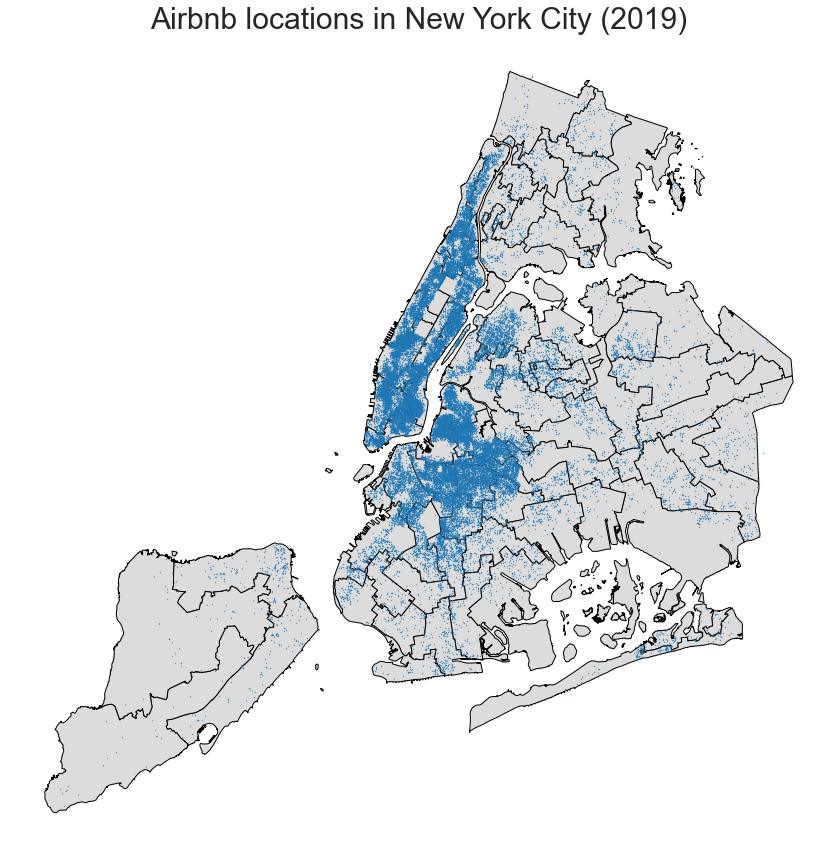

In [12]:
sns.set_style("white")
ax = nyc.plot(figsize = (15,15), color = 'gainsboro', edgecolor = 'black')
ax.set_axis_off()

plt.title("Airbnb locations in New York City (2019)", size = 30)
Airbnb_geo.plot(markersize=0.1, ax=ax)

plt.savefig ("NYC_locations", dpi=300, bbox_inches ="tight")
plt.show()

#### Number of apartments by borough

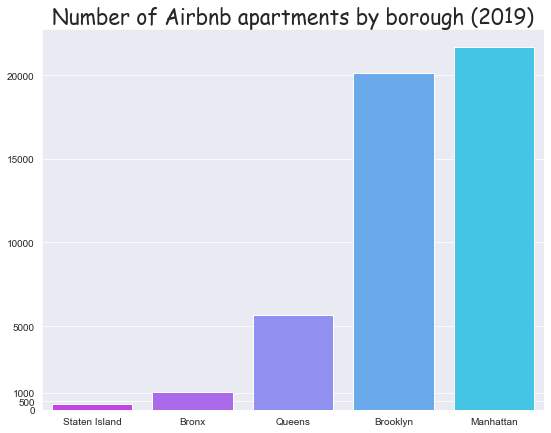

In [11]:
sum = Airbnb_geo.groupby('neighbourhood_group').count().sort_values('host_id')# count the values for each borough
                                                                              #and sort
sns.set_style("darkgrid")
plt.figure(figsize=(9,7))                                                     #general settings
plt.title ("Number of Airbnb apartments by borough (2019)", size = 21, fontname = "Comic Sans MS")

bar = sns.barplot (x=sum.index, y=sum.host_id, palette = "cool_r")

yticks = [* range(0,20001,5000)] # making a list for y-ticks. '[* range(start,stop,steps)]' converts range to list
bar.set_yticks([500,1000] + yticks) # adding values to the list and setting y-ticks list as y-ricks of the plot.
bar.set(xlabel= '', ylabel='') #removing auto generated x and y axis labels

plt.savefig ("number_of_apts.png",bbox_inches ="tight", dpi=300)
plt.show()

#### Top 100 most expensive apartments per night for each borough on one map, size of dot indicates cost, with legend, different color for each borough

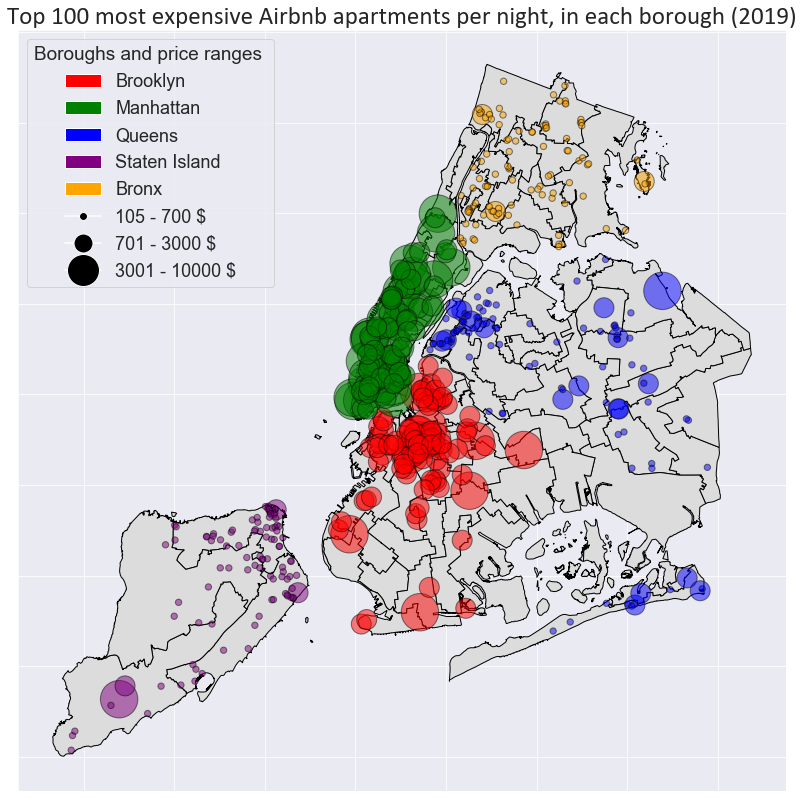

In [10]:
missing_values_count = Airbnb_geo.price.isnull().sum() #checking for missing price data

#inserting values to geodataframes by borough name, sorting peices (descending), and taking the top 100

Brooklyn = Airbnb_geo.loc[Airbnb_geo.neighbourhood_group == 'Brooklyn'].sort_values('price', ascending=False).head(100)
Manhattan = Airbnb_geo.loc[Airbnb_geo.neighbourhood_group == 'Manhattan'].sort_values('price', ascending=False).head(100)
Queens = Airbnb_geo.loc[Airbnb_geo.neighbourhood_group == 'Queens'].sort_values('price', ascending=False).head(100)
Staten_Island = Airbnb_geo.loc[Airbnb_geo.neighbourhood_group == 'Staten Island'].sort_values('price', ascending=False).head(100)
Bronx = Airbnb_geo.loc[Airbnb_geo.neighbourhood_group == 'Bronx'].sort_values('price', ascending=False).head(100)

sns.set_style("darkgrid")

#reintroducing the previously made nyc map
ax = nyc.plot(figsize = (14,14), color = 'gainsboro', edgecolor = 'black')

def size (series): #the function's input is a pandas dataseries of prices 
    list = [] #create an empty list
    
    for row in range(-1,len(series),1): #loop - starts from row 0, ends with the last row, 1 line per itiration
        if (series.values[row] < 701): #condition to be met
            list.append (40) #append a number to the list. the number represents the marker size of the plotted data.
        elif ((series.values[row] > 700) and (series.values[row] < 3001)):
             list.append (400)
        else:
            list.append (1400)

    return list #the function's output is a list of marker sizes to match each plotted entry. 
    

#plotting data using the "size" fuction, including edge color
ax1 = Brooklyn.plot(markersize=size(Brooklyn.price), ax=ax, color='red', alpha = 0.5, marker = 'o', edgecolors='black') 
ax2 = Manhattan.plot(markersize=size(Manhattan.price), ax=ax, color='green', alpha = 0.5, marker = 'o', edgecolors='black')
ax3 = Queens.plot(markersize=size(Queens.price), ax=ax, color='blue', alpha = 0.5, marker = 'o', edgecolors='black')
ax4 = Staten_Island.plot(markersize=size(Staten_Island.price), ax=ax, color='purple', alpha = 0.5, marker = 'o', edgecolors='black')
ax5 = Bronx.plot(markersize=size(Bronx.price), ax=ax, color='orange', alpha = 0.5, marker = 'o', edgecolors='black')



legend_elements = [Patch(facecolor='red',label='Brooklyn'), #creating a list of shape objects that contain color and label
                   Patch(facecolor='green',label='Manhattan'),
                   Patch(facecolor='blue',label='Queens'),
                   Patch(facecolor='purple',label='Staten Island'),
                   Patch(facecolor='orange',label='Bronx'),
                   
                   Line2D([0], [0], marker='o', color='white', label='105 - 700 $', markerfacecolor='black', markersize=8),
                   Line2D([0], [0], marker='o', color='white', label='701 - 3000 $', markerfacecolor='black', markersize=19),
                   Line2D([0], [0], marker='o', color='white', label='3001 - 10000 $', markerfacecolor='black', markersize=32)
                   ]

#creating the legend
plt.legend(title = "Boroughs and price ranges " ,title_fontsize=19,  handles=legend_elements, loc='upper left', fontsize=18)

plt.title ("Top 100 most expensive Airbnb apartments per night, in each borough (2019)", fontname = "Calibri", size = 25)

plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False) # remove ticks and axis labels

#plt.savefig("Top_100.png",bbox_inches ="tight", dpi=300)
plt.show()

#### General distrobution of prices

When planning the visualisation of the price range in the legend it's important to check the minimum and maximus values in each of the dataframes, in order to not misrepresent the data. checking the top 100, or even the top 500 in the dataset as it was before the separation, might result in wrong numbers.

#### Same first map but using Folium in different ways

In [22]:
#Heatmap

m_1 = folium.Map(location=[40.71427, -74.00597],tiles='openstreetmap', zoom_start=10)

HeatMap(data=Airbnb_geo[['latitude', 'longitude']], radius=12).add_to(m_1)

m_1.save("Heatmap.html")

In [20]:
#Markercluster

m_2 = folium.Map(location=[40.71427, -74.00597],tiles='cartodbpositron', zoom_start=10)

mc = MarkerCluster()
for idx, row in Airbnb_geo.iterrows():
        mc.add_child(Marker([row['latitude'], row['longitude']]))
m_2.add_child(mc)

m_2.save("MarkerCluster.html")

In [7]:
Airbnb_geo.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry
id,,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,POINT (991917.303 175175.655)
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,POINT (988746.648 213841.186)
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,POINT (1000333.670 234030.203)
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,POINT (995410.267 188893.967)
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,POINT (999757.550 230200.664)


In [44]:
#Choropleth map

boroughs = gpd.read_file(r'shape files\geo_export_ac60301a-5a5b-46ae-91c9-53608c1b0201.shp') #getting shp file with boroughs
boroughs = boroughs[["boro_name", "geometry"]].set_index("boro_name")
boroughs.index.rename('borough', inplace = True) #renaming the index column
Airbnb_geo.rename(columns = {'neighbourhood_group':'borough'}, inplace = True) #renaming a column

boro_num = Airbnb_geo.borough.value_counts() #the series from which the data is taken

m_3 = folium.Map(location=[40.71427, -74.00597],tiles='cartodbpositron', zoom_start=10)

Choropleth(geo_data=boroughs.__geo_interface__, 
           data=boro_num, 
           key_on="feature.id", 
           fill_color='BuPu', 
           legend_name="Number of Airbnb apartments by borough (2019)"
          ).add_to(m_3)

m_3.save("Choropleth.html")